In [1]:
!pip install torch torchvision
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = "/content/drive/My Drive/Wagon frames/train copy"
coco_json = f"{dataset_path}/_annotations.coco.json"

WARNING [01/31 06:58:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/31 06:58:54 d2.data.datasets.coco]: Loaded 24 images in COCO format from /content/drive/My Drive/Wagon frames/train copy/_annotations.coco.json


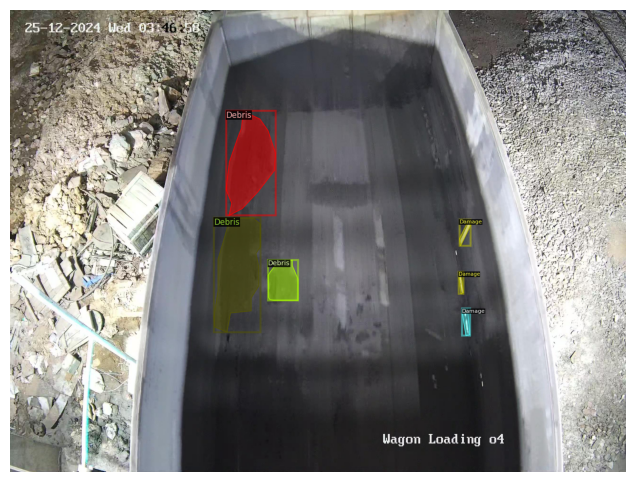

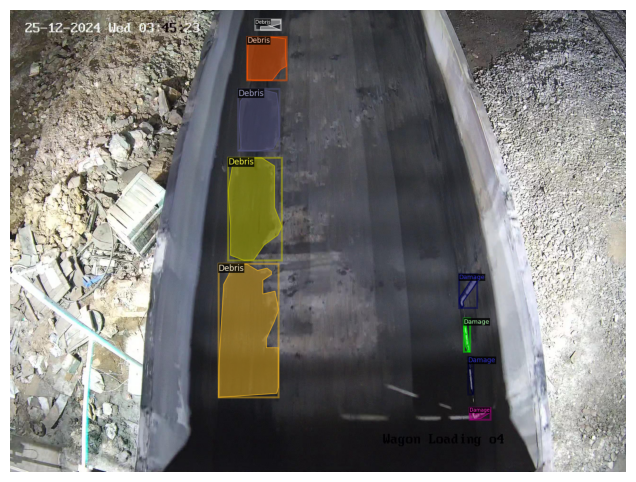

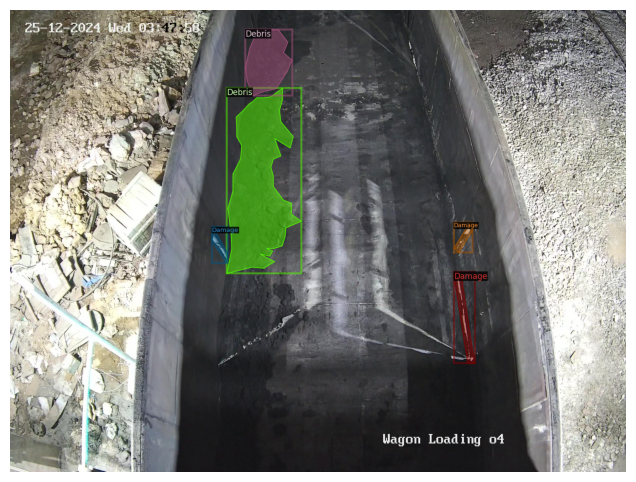

In [10]:
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
import cv2
import os

# Register dataset
register_coco_instances("wagon_train", {}, coco_json, dataset_path)

# Verify dataset
from detectron2.data import MetadataCatalog, DatasetCatalog
metadata = MetadataCatalog.get("wagon_train")
dataset_dicts = DatasetCatalog.get("wagon_train")

# Show sample images
import random
import matplotlib.pyplot as plt

for d in random.sample(dataset_dicts, 3):
    img_path = d["file_name"]
    img = cv2.imread(img_path)
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = v.draw_dataset_dict(d)

    plt.figure(figsize=(8, 6))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()

In [5]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.5 ; cuda:  cu124
detectron2: 0.6


In [11]:
import json
import os
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
import torch
from google.colab.patches import cv2_imshow

# Data and model paths (adjust if needed)
data_dir = "/content/drive/MyDrive/My First Project.v1i.coco-segmentation"
output_dir = "/content/drive/MyDrive/detectron2_output"

# Dataset Registration (Now includes "test")
for d in ["train", "valid", "test"]:
    json_file = os.path.join(data_dir, d, "_annotations.coco.json")
    image_dir = os.path.join(data_dir, d)
    register_coco_instances(f"my_dataset_{d}", {}, json_file, image_dir)

# Metadata
metadata = MetadataCatalog.get("my_dataset_train")
metadata.thing_classes = ["objects", "Damage", "Damege", "Debris", "Obstacle"]
metadata.thing_dataset_id_to_contiguous_id = {0:0, 1:1, 2:2, 3:3, 4:4}

# Detectron2 Configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# OR, if you have a local config file:
#cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.VAL = ("my_dataset_valid",)
cfg.DATASETS.TEST = ("my_dataset_test",)  # Include the test set

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2  # Adjust based on GPU
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # Adjust as needed
cfg.OUTPUT_DIR = output_dir

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Evaluation (Now includes evaluation on the test set)
evaluator = COCOEvaluator("my_dataset_valid", output_dir=cfg.OUTPUT_DIR) # Evaluate on validation set first
val_loader = build_detection_test_loader(cfg, "my_dataset_valid")
print("Evaluation on Validation Set:")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

evaluator = COCOEvaluator("my_dataset_test", output_dir=cfg.OUTPUT_DIR) # Then evaluate on test set
test_loader = build_detection_test_loader(cfg, "my_dataset_test")
print("Evaluation on Test Set:")
print(inference_on_dataset(trainer.model, test_loader, evaluator))


# Inference (Example - same as before)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

im = cv2.imread(os.path.join(data_dir, "test/path/to/your/test_image.jpg")) # Example: reading from the test directory
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to(torch.device("cpu")))

cv2_imshow(out.get_image()[:, :, ::-1])

[01/31 06:59:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
model_final_280758.pkl: 167MB [00:11, 14.3MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[01/31 06:59:59 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/31 07:00:34 d2.utils.events]:  eta: 0:11:42  iter: 19  total_loss: 4.543  loss_cls: 2.034  loss_box_reg: 0.04652  loss_rpn_cls: 2.145  loss_rpn_loc: 0.2985    time: 1.0482  last_time: 0.8134  data_time: 0.2032  last_data_time: 0.0236   lr: 4.9953e-06  max_mem: 2214M
[01/31 07:02:13 d2.utils.events]:  eta: 0:12:42  iter: 39  total_loss: 3.525  loss_cls: 1.835  loss_box_reg: 0.05259  loss_rpn_cls: 1.44  loss_rpn_loc: 0.1982    time: 1.3372  last_time: 1.1783  data_time: 0.0744  last_data_time: 0.0143   lr: 9.9902e-06  max_mem: 2215M
[01/31 07:02:44 d2.utils.events]:  eta: 0:12:22  iter: 59  total_loss: 2.585  loss_cls: 1.49  loss_box_reg: 0.08233  loss_rpn_cls: 0.7413  loss_rpn_loc: 0.1965    time: 1.4124  last_time: 1.0100  data_time: 0.0890  last_data_time: 0.1048   lr: 1.4985e-05  max_mem: 2215M
[01/31 07:03:12 d2.utils.events]:  eta: 0:11:36  iter: 79  total_loss: 1.746  loss_cls: 1.108  loss_box_reg: 0.1212  loss_rpn_cls: 0.2161  loss_rpn_loc: 0.1793    time: 1.4116  last_time: 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


WARNING [01/31 07:22:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/31 07:22:34 d2.data.datasets.coco]: Loaded 7 images in COCO format from /content/drive/MyDrive/My First Project.v1i.coco-segmentation/valid/_annotations.coco.json
[01/31 07:22:34 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  objects   | 0            |   Damage   | 22           |   Damege   | 0            |
|   Debris   | 20           |  Obstacle  | 0            |            |              |
|   total    | 42           |            |              |            |              |
[01/31 07:22:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[01/31 07:22:40 d2.evaluation.evaluator]: Total inference time: 0:00:00.275584 (0.275584 s / iter per device, on 1 devices)
[01/31 07:22:40 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.105187 s / iter per device, on 1 devices)
[01/31 07:22:40 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/31 07:22:40 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/detectron2_output/coco_instances_results.json
[01/31 07:22:40 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/31 07:22:40 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/31 07:22:40 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[01/31 07:22:40 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[01/31 07:22:40 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.03 s

/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# Inference (Example - same as before)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

im = cv2.imread(os.path.join(data_dir, "")) # Example: reading from the test directory
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to(torch.device("cpu")))

cv2_imshow(out.get_image()[:, :, ::-1])

[01/31 07:38:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/detectron2_output/model_final.pth ...


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Trying to read image at: /content/drive/MyDrive/My First Project.v1i.coco-segmentation/test/frame_1320_jpg.rf.4aee7ba0b6ca9bc34b30f0dcc2559dcf.jpg


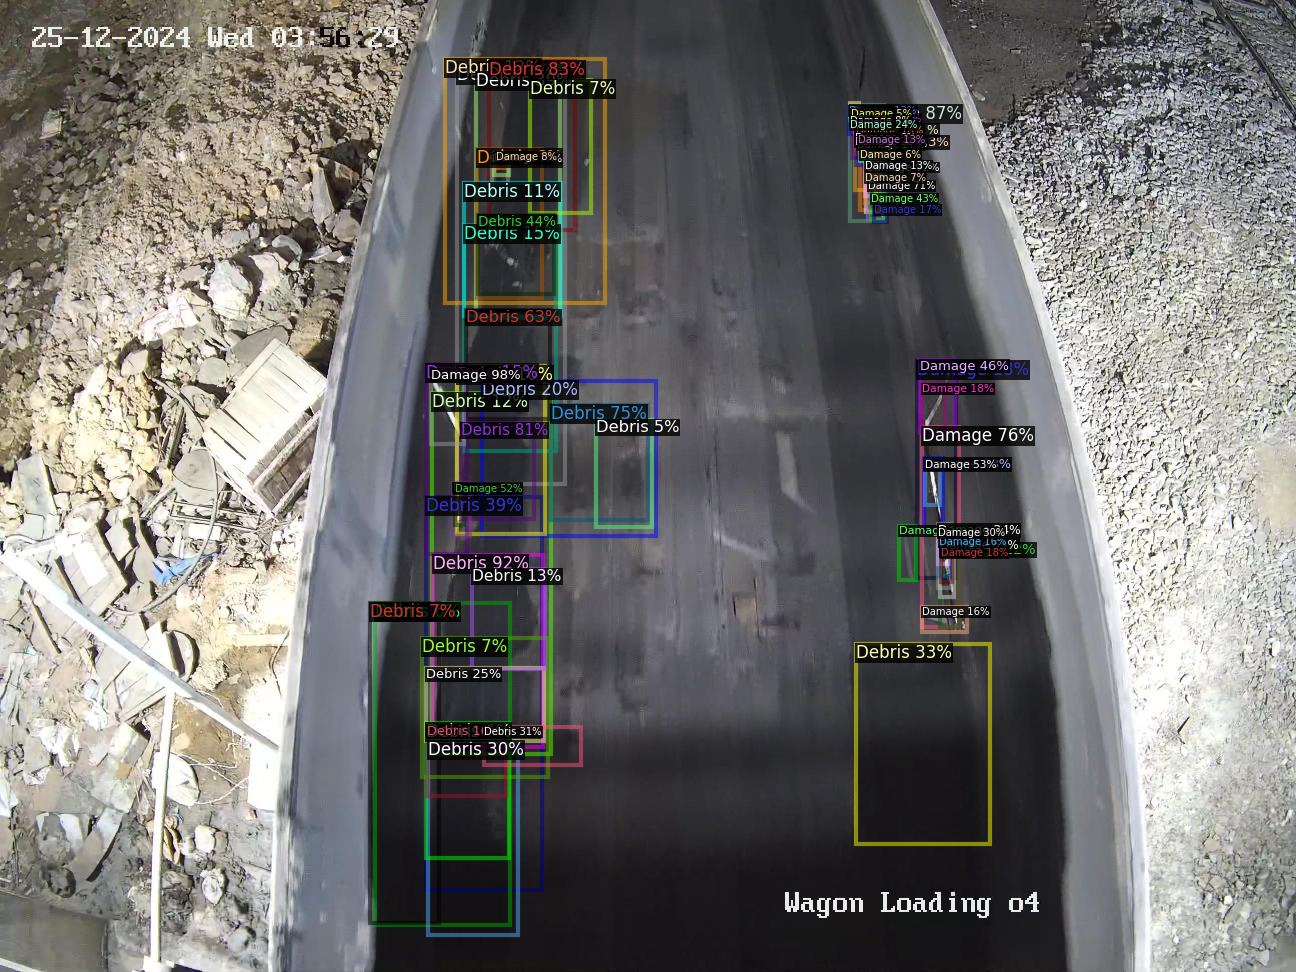

In [13]:
# ... (other code)

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

# *** REPLACE THIS WITH THE ACTUAL PATH TO YOUR TEST IMAGE ***
image_path = "/content/drive/MyDrive/My First Project.v1i.coco-segmentation/test/frame_1320_jpg.rf.4aee7ba0b6ca9bc34b30f0dcc2559dcf.jpg"  # Example - CHANGE THIS!
# OR
# image_path = os.path.join(data_dir, "test", "frame_1320_jpg.rf.4aee7ba0b6ca9bc34b30f0dcc2559dcf.jpg")  # Example - CHANGE THIS!

print(f"Trying to read image at: {image_path}") # Print the path for debugging
im = cv2.imread(image_path)

if im is None:
    print(f"ERROR: Could not read image at: {image_path}")  # Handle the error
else:
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to(torch.device("cpu")))

    cv2_imshow(out.get_image()[:, :, ::-1])